## Pseudocode FL

Create a list with the number of data points per client  
Create a variable for initial weights  
Create a variable for the maximum number of rounds  
Create an empty list for weighted average loss for each round  
Create an empty list for weighted average accuracy for each round  

For each round 'i' up to the maximum number of rounds:
- Create an empty list for the weights
- Create an empty list for validation loss of each client
- Create an empty list for validation accuracy of each client
- For each client:
    - Train the model
    - Get the model weights
    - Save the weights in the list of weights
    - Assign initial weights to the model
    - Save the client accuracy
    - Save the client loss
- Save the average loss of the clients
- Save the average accuracy of the clients
- Save the weighted average of the list of weights of the clients
- Assign the weighted average weights to the model
- Set the initial weights for the next round as the weighted average weights

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
np.random.seed(0)
import random as rn
rn.seed(0)
import matplotlib.pylab as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
tf.random.set_seed(0)

2023-06-20 09:29:17.468821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 09:29:17.590491: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Loading processed and curated dataset:
dfHeart = pd.read_csv("/srv/heart_ConditionalMeanImputation.csv")
dfHeart

,Sex_F,Sex_M,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ExerciseAngina_N,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,40,140.0,289.0,0,172,0.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,49,160.0,180.0,0,156,1.0,1
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,37,130.0,283.0,0,98,0.0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,48,138.0,214.0,0,108,1.5,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,54,150.0,195.0,0,122,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,45,110.0,264.0,0,132,1.2,1
914,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68,144.0,193.0,1,141,3.4,1
915,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,57,130.0,131.0,0,115,1.2,1
916,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,57,130.0,236.0,0,174,0.0,1


In [4]:
# X_clients = 9 # number of clients
# data_dict = {}

# for i in range(X_clients):
#   portion = 1/(X_clients)*len(dfHeart)
#   X = dfHeart.loc[i*portion:(i+1)*portion,:].drop(['HeartDisease'], axis=1)
#   y = dfHeart.loc[i*portion:(i+1)*portion,:]['HeartDisease']
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#   client_data = {
#       'X_train': X_train,
#       'X_test': X_test,
#       'y_train': y_train,
#       'y_test': y_test
#   }
#   data_dict[f'client_{i+1}'] = client_data

In [5]:
dfHeart["Name"]="name"
# Estimated (from raw data) slices for each hospital
dfHeart.loc[0:293,"Name"] = "hung" # Hungarian Institute of Cardiology, Budapest
# Author: Andras Janosi, M.D.
dfHeart.loc[293:477,"Name"] = "swit" # University Hospital (Zurich and Basel) Switzerland
# Author: William Steinbrunn, M.D. and Matthias Pfisterer, M.D respectively.
dfHeart.loc[477:615,"Name"] = "long" # V.A. Medical Center, Long Beach
# Author: Robert Detrano, M.D., Ph.D.
dfHeart.loc[615:766,"Name"] = "stat" # Statlog dataset (confidential source)
# Author: "King RD. Department of Statistics and Modelling Science, University of Strathclyde, Glasgow"
dfHeart.loc[766:918,"Name"] = "clev" # Cleveland Clinic Foundation
# Author: Robert Detrano, M.D., Ph.D.

In [22]:
# Each group is divided into train and test groups and scaled
# Creation of data_dict dictionary
data_dict = {}
groups = dfHeart.groupby('Name')

for name, group in groups:
    X = group.drop(['HeartDisease', 'Name'], axis=1)
    y = group['HeartDisease']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    # Judith: escalamos los datos
    X_train = X_train.values
    X_test = X_test.values
    scaler = MinMaxScaler()
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    # Filling data_dict dictionary
    data_dict[name] = {
      'X_train': X_train,
      'X_test': X_test,
      'y_train': y_train,
      'y_test': y_test
  }

In [8]:
data_dict.keys()

dict_keys(['clev', 'hung', 'long', 'stat', 'swit'])

In [9]:
#Creating neural network architecture
shape = data_dict[list(data_dict.keys())[0]]['X_train'].shape[1]
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", 
                metrics=["accuracy", "AUC"])

2023-06-20 09:29:20.171334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 09:29:20.175144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 09:29:20.175347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-20 09:29:20.176251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

In [10]:
def ave_weights(n_i,listOfWeights):
    """
    Aggregation function

   :param list n_i: Number of samples for each client
   :param list listOfWeights: Weights for each client
   :return: Final weighted average for global model
    """
    N = sum(n_i) # total number of samples of all clients
    # initial weights of global model, set to zero
    ave_weights = listOfWeights[0]
    ave_weights = [i * 0 for i in ave_weights]
    # loop whose range is number of clients
    for j in range(len(n_i)):
        # receive weights from clients
        rec_weight = listOfWeights[j]
        # multiply the client weights by number of local data samples in client local data
        rec_weight =  [i * n_i[j] for i in rec_weight]
        # divide the weights by total number of samples of all clients
        rec_weight =  [i / N for i in rec_weight]
        # sum the weights of new client with the prior
        ave_weights = [x + y for x, y in zip(ave_weights,rec_weight)]
    return ave_weights

In [11]:
def weighted_mean(n_i, metric_list):
    """
    Calculate the weighted mean of an evaluation metric.

    :param list n_i: Number of samples for each client
    :param list metric_list: List of evaluation metric values for each client
    :return: Weighted mean of the evaluation metric
    """
    total_samples = sum(n_i)  # Total number of samples of all clients
    weighted_metric_sum = 0.0

    for j in range(len(n_i)):
        weighted_metric_sum += metric_list[j] * n_i[j]

    weighted_mean = weighted_metric_sum / total_samples
    return weighted_mean

-  Select a maximum number of rounds, leaving a validation set for each dataset.
-  Analyze the error/accuracy of the resulting model for each round in the validation of each dataset.
-  Calculate the weighted average of the error/accuracy for each round. In other words, for round i, we will have different error and accuracy values for each dataset. You can aggregate them (weighted based on the number of data points) and obtain the weighted average of the error and/or accuracy.

In [12]:
# List with number of samples for each client
n_i = [len(data_dict[name]['X_train']) for name in data_dict.keys()]

# Get initial weights from created model before loop
initial_weights = model.get_weights()

# # To save the weighted means of loss and accuracy
# avg_loss = list()
# avg_acc = list()

# Maximum number of rounds n_times
n_times = 300
# Judith: miramos la accuracy y la loss de la validación
loss_val_round = []
acc_val_round = []

for i in range(1,n_times+1):
    
    # Get the initial weights:
    save_weights = list()
    
    # Generate weights for each client
    acc_val = []
    loss_val = []
    for name in data_dict.keys():
      # Train client:
      history = model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38, 
                          validation_split=0.15, verbose=0)
      # Obtain client weights:
      weights_client = model.get_weights()
      # Save weights:
      save_weights.append(weights_client)
      model.set_weights(initial_weights)
      acc_val.append(history.history['val_accuracy'][-1])# Judith: Accuracy en la validación la última época
      loss_val.append(history.history['val_loss'][-1])
    # Weighted metric average
    # Judith: en cada ronda, guardamos la media de la accuracy y la loss de la validación en cada cliente
    acc_val_round.append(weighted_mean(n_i,acc_val))
    loss_val_round.append(weighted_mean(n_i,loss_val))
    
    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = ave_weights(n_i,save_weights) # use of aggregation function
    model.set_weights(avg_weights)
    initial_weights = avg_weights
    
#     # Evaluate model with test data for each client and calculate average test loss and accuracy
#     test_loss_list = []
#     test_accuracy_list = []
#     for name in data_dict.keys():
#         score = model.evaluate(data_dict[name]['X_test'], data_dict[name]['y_test'], verbose=0)
#         test_loss_list.append(score[0])
#         test_accuracy_list.append(score[1])
    
#     # Saving weighted means for each round
#     avg_loss.append(weighted_mean(n_i, test_loss_list))
#     avg_acc.append(weighted_mean(n_i, test_accuracy_list))

2023-06-20 09:29:24.527447: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x3152abf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-20 09:29:24.527592: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-06-20 09:29:24.543042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-20 09:29:24.710992: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Once you have that weighted average for validation, select the optimal number of rounds that need to be repeated for the FL architecture.

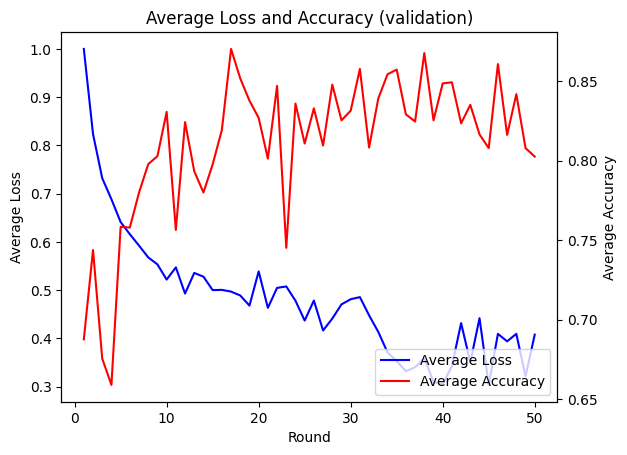

In [13]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()


# Convert the list to a NumPy array
loss_val_round_np = np.array(loss_val_round)

# Plot the average loss on the left y-axis

ax1.plot(range(1, n_times + 1), loss_val_round_np/max(loss_val_round_np), label='Average Loss', color='blue')
# Explica que aquí no es la loss lo que pones en el plot, si no la versión normalizada
ax1.set_xlabel('Round')
ax1.set_ylabel('Normalized Average Loss')
ax1.tick_params(axis='y')

# Create a twin axes on the right side
ax2 = ax1.twinx()

ax2.plot(range(1, n_times + 1), acc_val_round, label='Average Accuracy', color='red')
ax2.set_ylabel('Average Accuracy')
ax2.tick_params(axis='y')

# Set the title
plt.title('Normalized Average Loss and Average Accuracy (validation)')

# Add legends
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, [line.get_label() for line in lines])

# Display the plot
plt.show()

In [14]:
acc_val_round

[0.6876421749591828,
 0.7437972307205201,
 0.6755294620990753,
 0.6589890658855438,
 0.7583938241004944,
 0.7579386472702027,
 0.7799624562263489,
 0.7977962493896484,
 0.8028467535972595,
 0.83068288564682,
 0.7564500212669373,
 0.8242254614830017,
 0.7933229446411133,
 0.7799794316291809,
 0.7976381540298462,
 0.8192969679832458,
 0.8702571988105774,
 0.8516965866088867,
 0.8376994848251342,
 0.8269448757171631,
 0.801259446144104,
 0.8470026016235351,
 0.7451988458633423,
 0.8358914852142334,
 0.8107832551002503,
 0.8329152941703797,
 0.8094845652580261,
 0.8478546023368836,
 0.8253575801849365,
 0.8314181804656983,
 0.8576266884803772,
 0.8082622528076172,
 0.8390883684158326,
 0.8542939901351929,
 0.8572701811790466,
 0.8290955781936645,
 0.8246222853660583,
 0.8676375150680542,
 0.8253575801849365,
 0.8485898971557617,
 0.8492434978485107,
 0.8234816670417786,
 0.835079801082611,
 0.8164873600006104,
 0.8078972578048706,
 0.8607333898544312,
 0.8161902785301208,
 0.84179399013519

In [15]:
# The best equilibrium between acc_val_round and loss_val_round is found at the round 32
max_acc_round = np.argmax(acc_val_round) + 1
max_acc_round

17

In [16]:
optim_acc = acc_val_round[max_acc_round-1]
optim_loss = loss_val_round[max_acc_round-1]
print(" optim_acc:",optim_acc)
print(" optim_loss:",optim_loss)

 optim_acc: 0.8702571988105774
 optim_loss: 1.77309148311615


Repeat the process without using validation (i.e., now we do not leave data aside for validation since validation has already been done previously).

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(shape,), activation="relu", kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=256, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", 
                metrics=["accuracy", "AUC"])

In [18]:
# Get initial weights from created model before loop
initial_weights = model.get_weights()

# Repeat n_times train clients data, average their weights to set on global model and save it
n_times = max_acc_round
for i in range(1,n_times+1):
    
    # Get the initial weights:
    save_weights = list()
    
    # Generate weights for each client
    for name in data_dict.keys():
        # Train client:
        # callbacks = [keras.callbacks.EarlyStopping(patience=25)]
        #model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=12, batch_size=40,verbose=0) 
        # Judith: en el modelo en el que usabas la validación para obtener el número de rondas óptimo ponías epochs=14, batch_size=38
        model.fit(data_dict[name]['X_train'],data_dict[name]['y_train'], epochs=14, batch_size=38,verbose=0) 
        # Obtain client weights:
        weights_client = model.get_weights()
        # Save weights:
        save_weights.append(weights_client)
        model.set_weights(initial_weights)

    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = ave_weights(n_i,save_weights) # use of aggregation function
    model.set_weights(avg_weights)
    initial_weights = avg_weights
    
model.save('model_final.h5')    

In [19]:
# # Aquí estás volviendo a entrenar, tendrías que evaluar directamente los resultados en test con el último modelo tras agregar (y mirar el train de cada cliente)
# # history = model.fit(X_train,y_train, epochs=14, batch_size=38, verbose=0)
# for name in data_dict.keys():
#     print(f'Client: {name}')
#     score_train = model.evaluate(data_dict[name]['X_train'],data_dict[name]['y_train'], verbose = 0)
#     print(f'Train loss: {score_train[0]}')
#     print(f'Train accuracy: {score_train[1]}')
#     print(f'Train AUC: {score_train[2]}\n')

Client: clev
Train loss: 0.15332111716270447
Train accuracy: 0.9649122953414917
Train AUC: 0.9960936903953552

Client: hung
Train loss: 0.23647134006023407
Train accuracy: 0.931506872177124
Train AUC: 0.9841997623443604

Client: long
Train loss: 0.25745445489883423
Train accuracy: 0.9514563083648682
Train AUC: 0.952531635761261

Client: stat
Train loss: 0.3334081470966339
Train accuracy: 0.9026548862457275
Train AUC: 0.9678884744644165

Client: swit
Train loss: 0.2705063223838806
Train accuracy: 0.9420289993286133
Train AUC: 0.9351851940155029



In [21]:
for name in data_dict.keys():
    print(f'Client: {name}')
    score_test = model.evaluate(data_dict[name]['X_test'],data_dict[name]['y_test'], verbose = 0)
    print(f'Test loss: {score_test[0]}')
    print(f'Test accuracy: {score_test[1]}')
    print(f'Test AUC: {score_test[2]}\n')

Client: clev
Train loss: 1.5131324529647827
Train accuracy: 0.7631579041481018
Train AUC: 0.7160665392875671

Client: hung
Train loss: 0.5427896976470947
Train accuracy: 0.8783783912658691
Train AUC: 0.939166784286499

Client: long
Train loss: 0.3975851833820343
Train accuracy: 0.8571428656578064
Train AUC: 0.9401710033416748

Client: stat
Train loss: 1.4062280654907227
Train accuracy: 0.6842105388641357
Train AUC: 0.7767857313156128

Client: swit
Train loss: 0.5475509762763977
Train accuracy: 0.8695651888847351
Train AUC: 0.7697368860244751



Maybe it overfits because I trained a model with the same data points when cross-validated.